# Модели прогнозрования объемов sell in в период промо в зависимости от скидки, продолжительности промо, и клиента

суть идеи заключается в том, чтобы понять при какой продолжительности промо и размере скидки клиеты берут больше, чтобы не давать лишнего без должного аплифта. 

факторы укрупнила в категориальные переменные где возможно, т.к. мало данных и чтобы нагляднее было. клиентов объединила в группы на основе

прогнозировала по brand family 

### Оглавление <a class="anchor" id="begin"></a>

* [Подготовка данных](#data)
* [SVC](#1)
* [DecisionTreeRegressor](#2)
* [KNeighborsRegressor](#3)
* [RandomForestRegressor](#4)
* [GradientBoostingRegressor](#5)
* [линейная регрессия](#5.5)
* [Прогнозные значения по всем моделям](#6)
* [Heatmaps прогнозов](#7)
* [проверка гипотез о равенстве среднего объема при разных скидках](#8)

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats as st

### Подготовка данных <a class="anchor" id="data"></a>

In [2]:
df=pd.read_excel('promo1.xlsx', usecols=['Channel', 'Plan Accounts', 'Deal Start (Mars calendar)', 
                                        'Deal End (Mars calendar)','Deal date start', 'RU Category',
                                        'Deal date end', 'ZREP', 'Discount of NRV %', 
                                         'plan_Total VOD, CS','fact_Total VOD, CS'])
prod=pd.read_excel('Products.xlsx', usecols=['*DmdUnit', 'Brand Family', 'Brand'])

In [3]:
prod['*DmdUnit']=prod['*DmdUnit'].str.split('_').str[0].astype('int64')
df=df.merge(prod, left_on='ZREP', right_on='*DmdUnit', how='left')
df=df.drop(columns='*DmdUnit')

df=df.rename(columns={'Discount of NRV %':'discount',
                      'RU Category':'brand_family',
                      'Deal Start (Mars calendar)':'start_period',
                      'Deal End (Mars calendar)':'end_period',
                      'plan_Total VOD, CS':'plan',
                      'fact_Total VOD, CS':'fact'}) 

In [4]:
df['discount']=df['discount'].astype('int32')
df['Deal date start']=pd.to_datetime(df['Deal date start'], format="%Y%m%d")
df['Deal date end']=pd.to_datetime(df['Deal date end'], format="%Y%m%d")

# отфильтруем промо будующих периодов
df=df[df['Deal date end']<datetime.datetime.now()]

# DUMMY account for Template
df=df[df['Plan Accounts']!='DUMMY account for Template']

display(df.sample(1))
#df.info()

,Channel,Plan Accounts,Deal date start,start_period,Deal date end,end_period,brand_family,ZREP,discount,plan,fact,Brand Family,Brand
38802,National,Lenta,2020-08-13,2020P9W1,2020-09-09,2020P10W1,FC minis,320350,15,4062,4039.0,FC minis,MILKY WAY


есть 5 строк со скидками больше 1000, возможно баг в системе, и запятая поставилась не там. разделим на 100, тогда они будут в интервале допустимых значений

In [5]:
#скидки больше 100 делим на 100
df['discount']=np.where(df['discount']>100, df['discount']/100, df['discount'])

**расчет вспомагательных столбцов**

посчитаем сколько кейсов было продано за день промо, чтобы минимизировать влияние продолжительности промо, т.к. сильный разброс, и очевидно ожидать больших объемов на длительных промо

In [6]:
# продалжительность промо
df['duration']=df['Deal date end']-df['Deal date start']
df['duration']=pd.to_numeric(df['duration'].dt.days, downcast='integer')
df['duration']=df['duration']+1

# кейс/день
df['cs_per_day']=round(df['fact']/df['duration'], 2)

# столбец с номером периода для учета сезонности
df['period']=df['start_period'].str.split('P', 1).str[1]
df['period']=df['period'].str.split('W', 1).str[0]
df['period']=df['period'].astype('int8')

In [7]:
df['log_cs']=np.log(df['cs_per_day'])

**проверка на выбросы**

In [8]:
df['brand_family'].unique()

array(['Boxes', 'Tablets', 'Gifting', 'FC multipack',
       'Choco Bite size TH', 'FC minis', 'Loose', 'Gum OTC', 'Gum XXL',
       'Other Gum', 'CNF Bite size TH', 'Impulse Bars', 'Gum MP',
       'Choco Bite size Other', 'CNF Bite size impulse', 'Gum Bottle',
       'Other CNF', 'Other Choco', 'Choco Bite size impulse', 'Gum Bag',
       'Missing', 'Ice-cream'], dtype=object)

можно выбрать brand family из списка выше

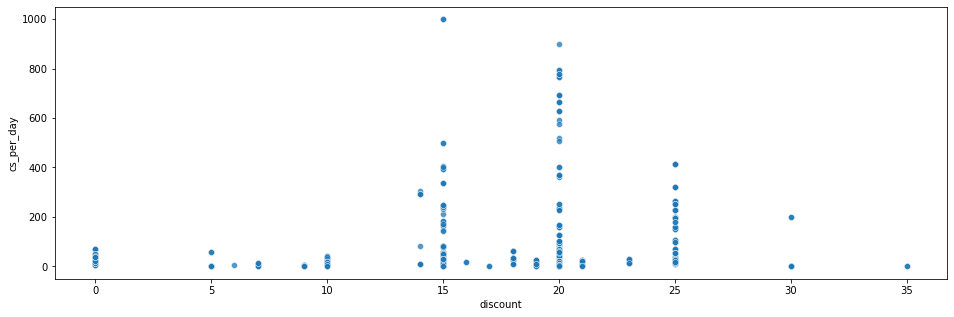

In [9]:
bf='FC multipack'
df=df[df['brand_family']==bf]

      
plt.figure(figsize=(16, 5))
sns.scatterplot(x=df['discount'], y=df['cs_per_day'],  alpha=.75)
None

выбросы есть, удалим их

In [10]:
percent=np.percentile(df['cs_per_day'], 99.8) 
print(f'cs_per_day 99.8% percentile = {percent}, \nудалим все объемы, которые больше него')

df=df[df['cs_per_day']<percent]

cs_per_day 99.8% percentile = 804.4588799999964, 
удалим все объемы, которые больше него


**перевод в категориальные переменные**

Размер скидки
- 1-5% = 5
- 6-10% = 10
- 11-15% = 15 и т.д.

продолжительность промо
- до 7 дней = 1
- 8-14 = 2
- 15-21 = 3 и т.д. в полных неделях, окугляя в большую сторону

группа клиентов по медианному заказу
- до 50% клиентов с минимальными медианными заказами = 4 
- 50%-75% = 3
- 75%-90% = 2
- 90%-100% = 1

In [11]:
# дни в недели
df['duration_weeks']=(df['duration']/7).apply(np.ceil)
df['duration_weeks']=df['duration_weeks'].astype('int16')

# размер скидки
df['discount_cathegory']=df['discount']
df['discount_cathegory']=round(df['discount_cathegory'], 0).astype('int16')

def cathegory(col, discount):
    df.loc[(df[col]>discount[0])&(df[col]<=discount[1]), col]=discount[2]

def discount(a):
    return(a, a+5, a+5)

for i in range(0, 95, 5):
    cathegory('discount_cathegory', discount(i))

In [12]:
#группа клиентов
client_groups=df.groupby('Plan Accounts', as_index=False).agg({'cs_per_day':'median'})
client_groups['client_caths']=pd.qcut(client_groups['cs_per_day'], q=[0, .5, .75, .90, 1], 
                               labels=['4', '3', '2', '1'])
client_groups['client_caths']=client_groups['client_caths'].astype('int8')
display(client_groups.sort_values('cs_per_day', ascending=False))
        
client_groups=client_groups[['Plan Accounts', 'client_caths']]
df=df.merge(client_groups, on='Plan Accounts', how='left')

,Plan Accounts,cs_per_day,client_caths
12,Monetka Ural,240.000,1
0,5Pyaterochka (X5),200.990,1
15,Red & White,158.800,2
8,Magnit,54.000,2
1,Auchan Group,40.460,2
14,Perekrestok (X5),34.760,3
2,Dixy,16.615,3
7,Lenta,16.320,3
13,Okey Group,15.750,3
11,Metro,14.445,4


- укрупнение групп периодов (на периода с высоким и низким спросом) не сработало, качество моделей падает.

In [13]:
df['cs_per_day']=round(df['cs_per_day'],0)
df['discount_cathegory']=round(df['discount_cathegory'],0)

X=df[['discount_cathegory', 'duration_weeks', 'client_caths']] 
y=df['cs_per_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
# фунуция для вывода метрик

def metrics(y_pred):
    print('MAE: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
    print('MSE: {:.2f}'.format(mean_squared_error(y_test, y_pred)))
    print('R2: {:.2f}'.format(r2_score(y_test, y_pred)))

#### DecisionTree <a class="anchor" id="2"></a>

In [15]:
model_1 =  DecisionTreeRegressor(max_depth=3)
model_1.fit(X_train, y_train)
y_pred_tree = model_1.predict(X_test)

metrics(y_pred_tree) 

MAE: 24.82
MSE: 2551.18
R2: 0.78


#### KNeighbors <a class="anchor" id="3"></a>

In [16]:
model_2=KNeighborsRegressor(n_neighbors=3, p=1) 
model_2.fit(X_train, y_train)
y_pred_khn=model_2.predict(X_test)

metrics(y_pred_khn)

MAE: 17.65
MSE: 1261.59
R2: 0.89


#### RandomForest <a class="anchor" id="4"></a>

In [17]:
model_3 =  RandomForestRegressor(n_estimators=5,
                                 oob_score=False, 
                                 random_state=1)
model_3.fit(X_train, y_train)
y_pred_rand = model_3.predict(X_test)

metrics(y_pred_rand)

MAE: 18.42
MSE: 1672.56
R2: 0.86


#### GradientBoosting <a class="anchor" id="5"></a>

In [18]:
model_4 =  GradientBoostingRegressor(n_estimators=5000, random_state=0)
model_4.fit(X_train, y_train)
y_pred_xb = model_4.predict(X_test)

metrics(y_pred_xb)

MAE: 17.69
MSE: 1382.77
R2: 0.88


#### линейная регрессия <a class="anchor" id="5.5"></a>

In [19]:
model_6 = Ridge() 
model_6.fit(X_train, y_train)
y_pred_ridge = model_6.predict(X_test) 

features = pd.DataFrame({'feature':X_train.columns, 'coeff':model_6.coef_})
print(features.sort_values('coeff', ascending=False))

metrics(y_pred_ridge)

              feature      coeff
0  discount_cathegory   0.304451
1      duration_weeks  -1.022848
2        client_caths -64.203579
MAE: 48.05
MSE: 7564.72
R2: 0.35


#### Прогнозные значения по всем моделям <a class="anchor" id="6"></a>

чтобы вывести объем при заданных параметрах введи их ниже

In [20]:
discount=15
duration=3
client_cathegory=1

x_pred=pd.DataFrame([[discount, duration, client_cathegory]],
              columns=['discount_cathegory', 'duration_weeks', 'client_caths']) 

print(f'прогнозные значения при скидке {discount}%, продолжительноси промо {duration} недель, для канала {1}')
print('----------------------------------------------------------------------------------- ')

y_pred = model_1.predict(x_pred)
print(f'DecisionTree = {y_pred[0]}')
y_pred = model_2.predict(x_pred)
print(f'KNeighbors = {y_pred[0]}')
y_pred = model_3.predict(x_pred)
print(f'RandomForest = {y_pred[0]}')
y_pred = model_4.predict(x_pred)
print(f'XGBoost = {y_pred[0]}')
y_pred = model_6.predict(x_pred)
print(f'Ridge = {y_pred[0]}')

прогнозные значения при скидке 15%, продолжительноси промо 3 недель, для канала 1
----------------------------------------------------------------------------------- 
DecisionTree = 526.7272727272727
KNeighbors = 81.0
RandomForest = 553.4109523809524
XGBoost = 717.0205125614749
Ridge = 179.63923186144007


#### Heatmaps <a class="anchor" id="7"></a>

создадим тепловую карту со всеми возможными комбинациями скидки и продолжительности при фиксированном периоде и канале.

для тепловой карты сгенерим датафрейм, где период и клиент будут заданы, а объем будет высчитываться от изменений скидки и длительности

In [21]:
client_cathegory=3

In [22]:
'''
генерим dataframe с помощью модели с наибольшим r2
''' 
x1=r2_score(y_test, y_pred_tree)
x2=r2_score(y_test, y_pred_khn)
x3=r2_score(y_test, y_pred_rand)
x4=r2_score(y_test, y_pred_xb)
x6=r2_score(y_test, y_pred_ridge)

models={x1:model_1, x2:model_2, x3:model_3, x4:model_4, x6:model_6} 

rows_list = []
dict1 = {}

for discount in range(0, (df.loc[df['client_caths']==client_cathegory, 'discount_cathegory']).max()+5, 5): 
    for duration in range(1, (df.loc[df['client_caths']==client_cathegory,'duration_weeks']).max()+1): 
        x_pred=pd.DataFrame([[discount, duration, client_cathegory]], 
                      columns=['discount_cathegory', 'duration_weeks', 'client_caths'])
        y_pred = models.get(max(models.keys())).predict(x_pred)

        rows_list.append([discount, duration, y_pred[0], y_pred[0]*duration*7]) 
        
data = pd.DataFrame(rows_list, columns=['discount_cathegory', 'duration_weeks', 
                                        'predict_cs_per_day', 'predict_total_cs_per_duration']) 

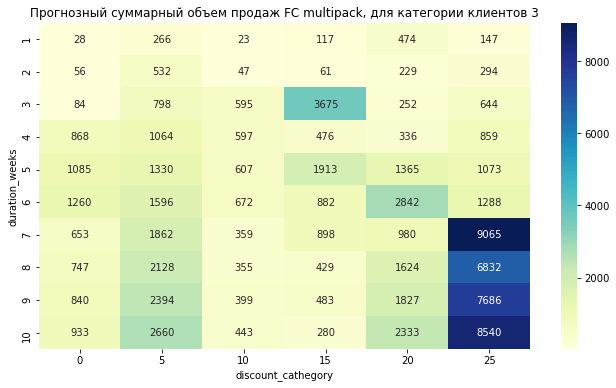

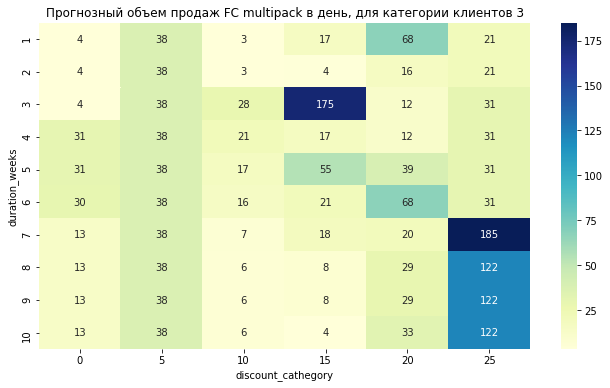

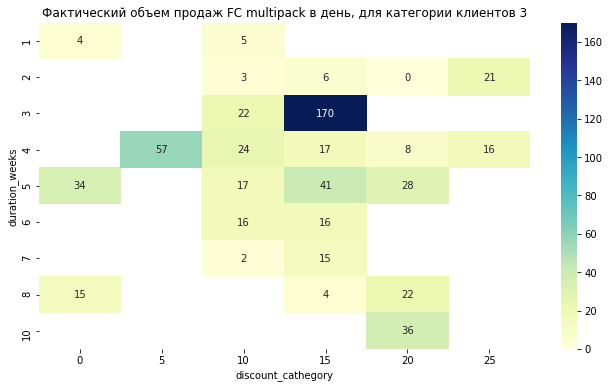

In [23]:
heatmap_df1=data.pivot_table(index='duration_weeks', 
                            columns='discount_cathegory', 
                            values='predict_total_cs_per_duration')
heatmap_df2=data.pivot_table(index='duration_weeks', 
                            columns='discount_cathegory', 
                            values='predict_cs_per_day')

plt.figure(figsize=(11, 6))
sns.heatmap(data=heatmap_df1, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title(label=f'Прогнозный суммарный объем продаж {bf}, для категории клиентов {client_cathegory}')
None

plt.figure(figsize=(11, 6))
sns.heatmap(data=heatmap_df2, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title(label=f'Прогнозный объем продаж {bf} в день, для категории клиентов {client_cathegory}')
None

df1=df[(df['client_caths']==client_cathegory)]
df1=df1.pivot_table(index='duration_weeks', 
                    columns='discount_cathegory', 
                    values='cs_per_day', 
                    aggfunc='median')
plt.figure(figsize=(11, 6))
sns.heatmap(data=df1, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title(label=f'Фактический объем продаж {bf} в день, для категории клиентов {client_cathegory}')
None